In [10]:
# INIT

import peer_list
import connections
import node_ids
import subnet_asns
import basic_evident
from constants import servers

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import maxminddb
import logging

logging.basicConfig(level=logging.INFO)

ban = 'without'

def ip_to_asn(ip_address, db_path='data/external/GeoLite2-ASN.mmdb'):
    try:
        with maxminddb.open_database(db_path) as reader:
            result = reader.get(ip_address)
            return result['autonomous_system_organization']
    except Exception as e:
        return None
    
anomaly_dict = {}

In [2]:
# Basic Summary
support_flags_sources, lastseen_sources, stats = basic_evident.basic_evident(ban)

anomaly_dict['SF Omission'] = {}
anomaly_dict['SF Omission']['ips'] = list(support_flags_sources)
anomaly_dict['SF Omission']['asns'] = list({ip_to_asn(ip) for ip in anomaly_dict['SF Omission']['ips']})

anomaly_dict['LS Transmission'] = {}
anomaly_dict['LS Transmission']['ips'] = list(lastseen_sources)
anomaly_dict['LS Transmission']['asns'] = list({ip_to_asn(ip) for ip in anomaly_dict['LS Transmission']['ips']})

INFO:root:Packets captured: 16894368
INFO:root:IPs connected to: 13050
INFO:root:IPs collected: 26919
INFO:root:Violation - nunique support_flags IPs: 1054
INFO:root:Violation - nunique last_seen IPs: 288


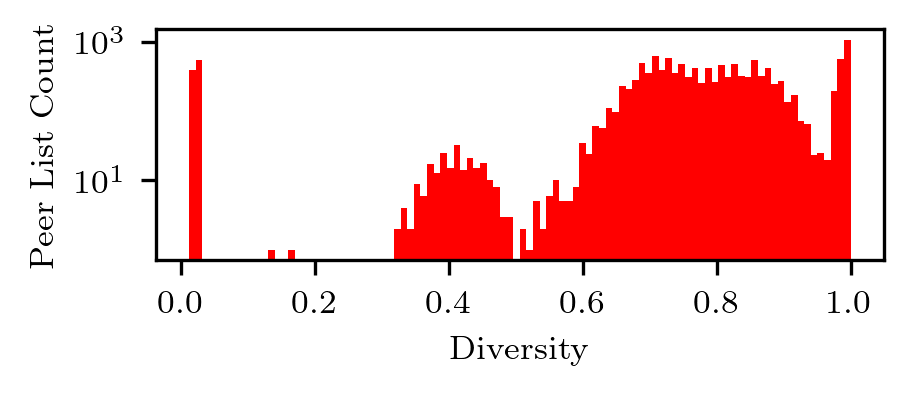

INFO:root:
INFO:root:PL Diversity - Unique IPs: 556
INFO:root:PL Diversity - Max announced subnets: 42
INFO:root:PL Diversity - Median announced subnets: 6.0


In [3]:
pl_div_ips, max_announced_subnets, median_announced_subnets = peer_list.peer_list_diversity(ban, threshold=0.2)
anomaly_dict['PL Diversity'] = {}
anomaly_dict['PL Diversity']['ips'] = list(pl_div_ips)
anomaly_dict['PL Diversity']['asns'] = list({ip_to_asn(ip) for ip in anomaly_dict['PL Diversity']['ips']})

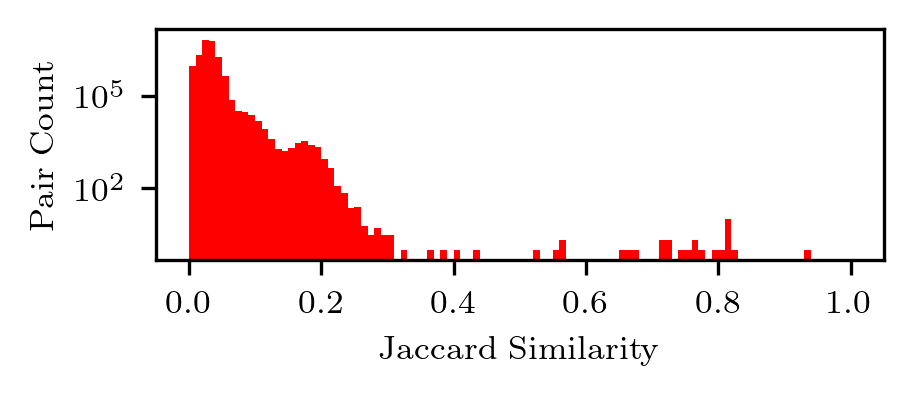

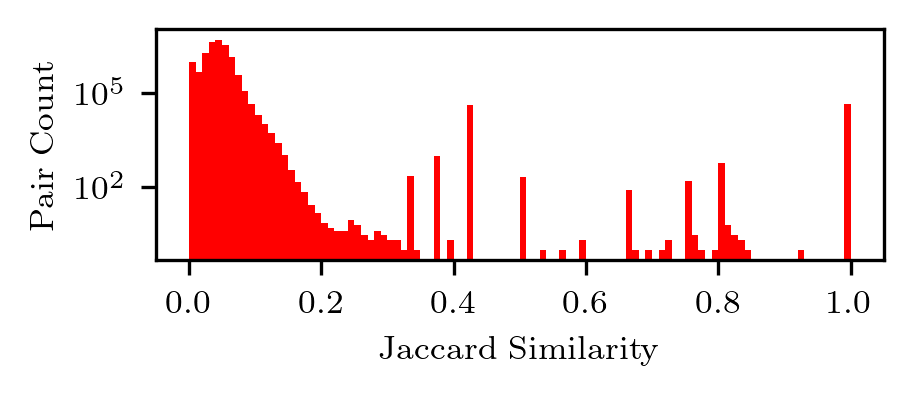

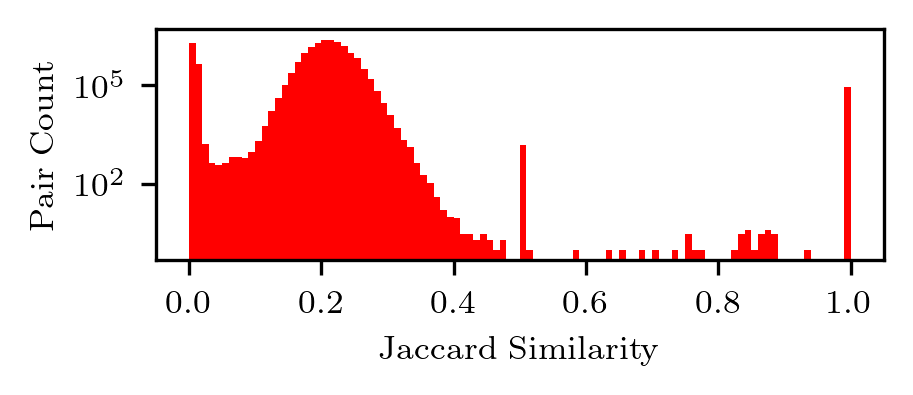

INFO:root:PL Similarity - Unique IPs: 566


In [ ]:

pl_sim_ips, overlap_df = peer_list.peer_list_similarity(ban, threshold=0.4)
anomaly_dict['PL Similarity'] = {}
anomaly_dict['PL Similarity']['ips'] = list(pl_sim_ips)
anomaly_dict['PL Similarity']['asns'] = list({ip_to_asn(ip) for ip in anomaly_dict['PL Similarity']['ips']})

In [2]:
sus_id_cluster_ips, sus_id_anomaly_ips, all_id_packets_df, multi_ip_clusters = node_ids.node_ids_inv(ban=ban)
#sus_id_cluster_ips, sus_id_anomaly_ips = node_ids.node_ids(ban=ban)
anomaly_dict['ID:IP Anomaly'] = {}
anomaly_dict['ID:IP Anomaly']['ips'] = list(sus_id_anomaly_ips)
anomaly_dict['ID:IP Anomaly']['asns'] = list({ip_to_asn(ip) for ip in anomaly_dict['ID:IP Anomaly']['ips']})

INFO:root:Found 5 ID:IP clusters
INFO:root:ID:IP - Cluster 1: 669 IDs map to 150 IPs
INFO:root:ID:IP - Cluster 2: 6 IDs map to 2 IPs
INFO:root:ID:IP - Cluster 3: 14 IDs map to 2 IPs
INFO:root:ID:IP - Cluster 4: 3 IDs map to 2 IPs
INFO:root:ID:IP - Cluster 5: 610 IDs map to 109 IPs


In [6]:
all_id_packets_df.keys()

Index(['frame_number', 'source_ip', 'source_port', 'dst_ip', 'dst_port',
       'timestamp', 'command', 'monero_flags', 'tcp_segments', 'tcp_length',
       'cumulative_difficulty', 'cumulative_difficulty_top64',
       'current_height', 'top_id', 'top_version', 'pruning_seed',
       'peerlist_length', 'local_time', 'my_port', 'network_id', 'peer_id',
       'support_flags', 'rpc_port', 'rpc_credits_per_hash', 'status',
       'block_ids', '_', 'block', 'current_blockchain_height', 'prune',
       'blocks', 'block_hash', 'missing_tx_indices'],
      dtype='object')

In [ ]:
def get_connection_info(row, my_ips, default_port):
    # Determine if outgoing (my_ips uses ephemeral port) or incoming (peer uses ephemeral port)
    if row['source_ip'] in my_ips and row['source_port'] != default_port:
        # Outgoing: my port is ephemeral
        return 'outgoing', row['dst_ip'], f"{row['source_ip']}:{row['source_port']}->{row['dst_ip']}:{row['dst_port']}"
    elif row['source_ip'] not in my_ips and row['dst_port'] != default_port:
        # Outgoing: peer is responding, but connection was initiated by me
        return 'outgoing', row['source_ip'], f"{row['dst_ip']}:{row['dst_port']}->{row['source_ip']}:{row['source_port']}"
    elif row['source_ip'] in my_ips and row['source_port'] == default_port:
        # Incoming: my port is default
        return 'incoming', row['dst_ip'], f"{row['source_ip']}:{default_port}<-{row['dst_ip']}:{row['dst_port']}"
    elif row['source_ip'] not in my_ips and row['dst_port'] == default_port:
        # Incoming: I'm responding, but connection was initiated by peer
        return 'incoming', row['source_ip'], f"{row['dst_ip']}:{default_port}<-{row['source_ip']}:{row['source_port']}"
    
my_ips = servers.keys()
default_port = "18080"
connection_info = all_id_packets_df.apply(get_connection_info, axis=1, args=(my_ips, default_port))
all_id_packets_df['direction'] = [info[0] for info in connection_info]
all_id_packets_df['peer_ip'] = [info[1] for info in connection_info]
all_id_packets_df['connection_key'] = [info[2] for info in connection_info]

In [12]:
connection_info

0         (incoming, 47.161.162.38, 143.198.236.154:1808...
1         (incoming, 162.218.65.219, 143.198.236.154:180...
2         (incoming, 162.218.65.219, 143.198.236.154:180...
3         (incoming, 162.218.65.219, 143.198.236.154:180...
4         (outgoing, 174.138.62.153, 143.198.236.154:415...
                                ...                        
127242    (incoming, 162.218.65.219, 134.199.160.172:180...
127243    (incoming, 162.218.65.219, 134.199.160.172:180...
127244    (incoming, 162.218.65.219, 134.199.160.172:180...
127245    (incoming, 104.199.89.5, 134.199.160.172:18080...
127246    (incoming, 162.218.65.219, 134.199.160.172:180...
Length: 157207, dtype: object

In [ ]:
all_id_packets_df = all_id_packets_df[all_id_packets_df['command'].isin(['1001', '1003'])]

all_id_packets_df[all_id_packets_df['source_ip'].isin(sus_id_anomaly_ips)].sort_values(['source_ip', 'timestamp'])[['source_ip', 'source_port', 'dst_ip', 'timestamp', 'peer_id', 'command']]

,source_ip,source_port,dst_ip,timestamp,peer_id,command
134048,1.160.138.108,55738,159.223.76.15,2025-06-02 14:07:22.334074,2.006023e+18,1001
102799,1.160.138.108,57132,134.199.160.172,2025-06-02 14:14:20.092473,9.420500e+18,1001
43438,1.160.138.108,54464,164.92.217.0,2025-06-02 17:08:00.790652,2.006023e+18,1001
77277,1.160.138.108,38528,167.71.228.106,2025-06-02 18:15:45.307567,9.420500e+18,1001
120015,1.160.138.108,33814,134.199.160.172,2025-06-03 03:17:11.713518,9.420500e+18,1001
...,...,...,...,...,...,...
142069,99.95.239.17,34056,159.223.76.15,2025-06-02 20:29:22.060629,1.022723e+19,1001
15853,99.95.239.17,18080,143.198.236.154,2025-06-02 20:35:04.064777,1.022723e+19,1001
23826,99.95.239.17,51486,143.198.236.154,2025-06-03 02:44:25.321898,1.022723e+19,1001
123232,99.95.239.17,56740,134.199.160.172,2025-06-03 05:45:20.541075,1.801889e+18,1001


In [9]:
all_id_packets_df[all_id_packets_df['source_ip'].isin(['1.160.138.108'])].sort_values(['source_ip', 'timestamp'])[['source_ip', 'source_port', 'dst_ip', 'timestamp', 'command', 'peer_id']]

,source_ip,source_port,dst_ip,timestamp,command,peer_id
134048,1.160.138.108,55738,159.223.76.15,2025-06-02 14:07:22.334074,1001,2.006023e+18
102799,1.160.138.108,57132,134.199.160.172,2025-06-02 14:14:20.092473,1001,9.420500e+18
43438,1.160.138.108,54464,164.92.217.0,2025-06-02 17:08:00.790652,1001,2.006023e+18
77277,1.160.138.108,38528,167.71.228.106,2025-06-02 18:15:45.307567,1001,9.420500e+18
120015,1.160.138.108,33814,134.199.160.172,2025-06-03 03:17:11.713518,1001,9.420500e+18
61306,1.160.138.108,34128,164.92.217.0,2025-06-03 05:51:18.664132,1001,2.006023e+18
94218,1.160.138.108,45932,167.71.228.106,2025-06-03 07:38:16.536657,1001,1.436871e+19


In [21]:
all_id_packets_df[all_id_packets_df['command'].isin(['1003'])]['source_ip'].unique()

array(['209.222.252.133', '100.42.27.40', '91.198.115.210',
       '91.198.115.203', '199.116.84.24', '193.142.4.47',
       '209.222.252.53', '100.42.27.189', '100.42.27.229',
       '209.222.252.14', '91.198.115.197', '209.222.252.13',
       '199.116.84.31', '91.198.115.124', '91.198.115.56', '193.142.4.38',
       '209.222.252.240', '209.222.252.76', '91.198.115.59',
       '91.198.115.71', '209.222.252.48', '100.42.27.230',
       '199.116.84.115', '100.42.27.224', '209.222.252.29',
       '100.42.27.143', '100.42.27.200', '91.198.115.209',
       '91.198.115.113', '199.116.84.223', '91.198.115.30',
       '193.142.4.76', '91.198.115.88', '100.42.27.86', '209.222.252.71',
       '91.198.115.83', '100.42.27.231', '209.222.252.87', '199.116.84.8',
       '91.198.115.170', '209.222.252.202', '199.116.84.30',
       '193.142.4.251', '193.142.4.147', '193.142.4.181', '193.142.4.230',
       '100.42.27.113', '100.42.27.83', '91.198.115.114',
       '91.198.115.156', '193.142.4.207', '20

In [6]:
sus_short, sus_ping, sus_ts, all_latencies = connections.connections(ban=ban, threshold=73)



anomaly_dict['Short-lived Conn'] = {}
anomaly_dict['Ping Flooding'] = {}
anomaly_dict['Throttled TS'] = {}

anomaly_dict['Short-lived Conn']['ips'] = list(sus_short)
anomaly_dict['Short-lived Conn']['asns'] = list({ip_to_asn(ip) for ip in anomaly_dict['Short-lived Conn']['ips']})
anomaly_dict['Ping Flooding']['ips'] = list(sus_ping)
anomaly_dict['Ping Flooding']['asns'] = list({ip_to_asn(ip) for ip in anomaly_dict['Ping Flooding']['ips']})
anomaly_dict['Throttled TS']['ips'] = list(sus_ts)
anomaly_dict['Throttled TS']['asns'] = list({ip_to_asn(ip) for ip in anomaly_dict['Throttled TS']['ips']})

INFO:root:Connections per IP, median: 1.0, mean: 4.928197226502311
INFO:root:Total connections of cat short_lived_1: 13105
INFO:root:Violation - short_lived_1_ten anomalies found for unique IPs: 10
INFO:root:Total connections of cat ping_flooding: 579
INFO:root:Violation - ping_flooding anomalies found for unique IPs: 501
INFO:root:Total connections of cat throttled_ts: 260
INFO:root:Violation - throttled_ts anomalies found for unique IPs: 229


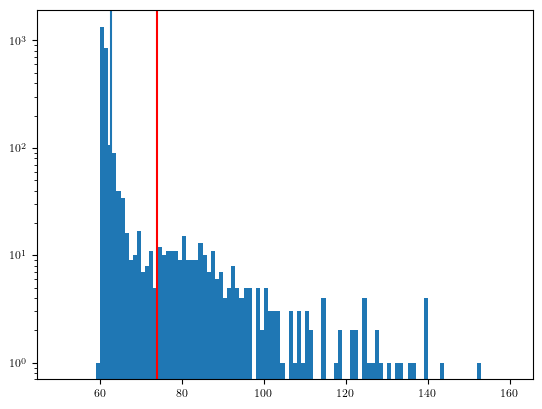

73.98548125


In [7]:
plt.hist(all_latencies, range=(50, 160), log=True, bins=110)
plt.axvline(all_latencies.quantile(0.8))
plt.axvline(all_latencies.quantile(0.9), color='red')
plt.show()
print(all_latencies.quantile(0.9))

with banlist: 72.66561520000002

In [8]:
banned_ips, signature_only_ips = connections.ban_and_signature(ban=ban)
anomaly_dict['Signature Only'] = {}
anomaly_dict['Signature Only']['ips'] = list(signature_only_ips)
anomaly_dict['Signature Only']['asns'] = list({ip_to_asn(ip) for ip in anomaly_dict['Signature Only']['ips']})

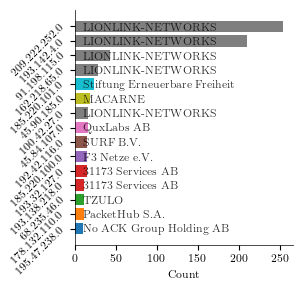

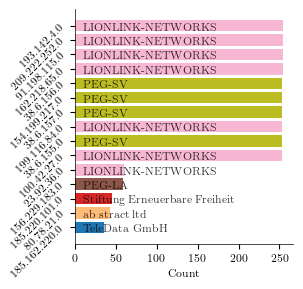

In [9]:
sus_subnet_ips = subnet_asns.subnets_asn(ban=ban)
subnet_asns.subnets_asn_ext(ban)
anomaly_dict['High Subnet Sat'] = {}
anomaly_dict['High Subnet Sat']['ips'] = list(sus_subnet_ips)
anomaly_dict['High Subnet Sat']['asns'] = list({ip_to_asn(ip) for ip in anomaly_dict['High Subnet Sat']['ips']})

In [10]:
anomaly_dict['Ban Listed'] = {}
anomaly_dict['Ban Listed']['ips'] = list(banned_ips)
anomaly_dict['Ban Listed']['asns'] = list({ip_to_asn(ip) for ip in anomaly_dict['Ban Listed']['ips']})

In [11]:
for entry in anomaly_dict:
    print(f"{entry}: {len(anomaly_dict[entry]['ips'])} unique IPs")
    print(f"    {len(anomaly_dict[entry]['asns'])} unique ASs")
    if len(anomaly_dict[entry]['asns']) < 11:
        print(anomaly_dict[entry]['asns'])

SF Omission: 1054 unique IPs
    80 unique ASs
LS Transmission: 288 unique IPs
    1 unique ASs
['LIONLINK-NETWORKS']
PL Diversity: 556 unique IPs
    3 unique ASs
['LIONLINK-NETWORKS', 'Kyivstar PJSC', 'Industrial Media Network LLC']
PL Similarity: 566 unique IPs
    8 unique ASs
['DIGITALOCEAN-ASN', 'Telefonica Germany', 'Digi Spain Telecom S.l.', 'Fredrik Holmqvist', 'LIONLINK-NETWORKS', 'MACARNE', 'QuxLabs AB', 'BGPNET PTE. LTD.']
ID:IP Anomaly: 635 unique IPs
    150 unique ASs
Short-lived Conn: 10 unique IPs
    7 unique ASs
['M247 Europe SRL', 'OVH SAS', 'CRUNCHBITS', 'LIONLINK-NETWORKS', 'RELIABLESITE', 'Hetzner Online GmbH', 'AS-COLOCROSSING']
Ping Flooding: 501 unique IPs
    1 unique ASs
['LIONLINK-NETWORKS']
Throttled TS: 229 unique IPs
    121 unique ASs
Signature Only: 1201 unique IPs
    5 unique ASs
['DIGITALOCEAN-ASN', 'CETIN Bulgaria EAD', 'LIONLINK-NETWORKS', 'Hetzner Online GmbH', 'GOOGLE-CLOUD-PLATFORM']
High Subnet Sat: 988 unique IPs
    10 unique ASs
['SURF B.V.

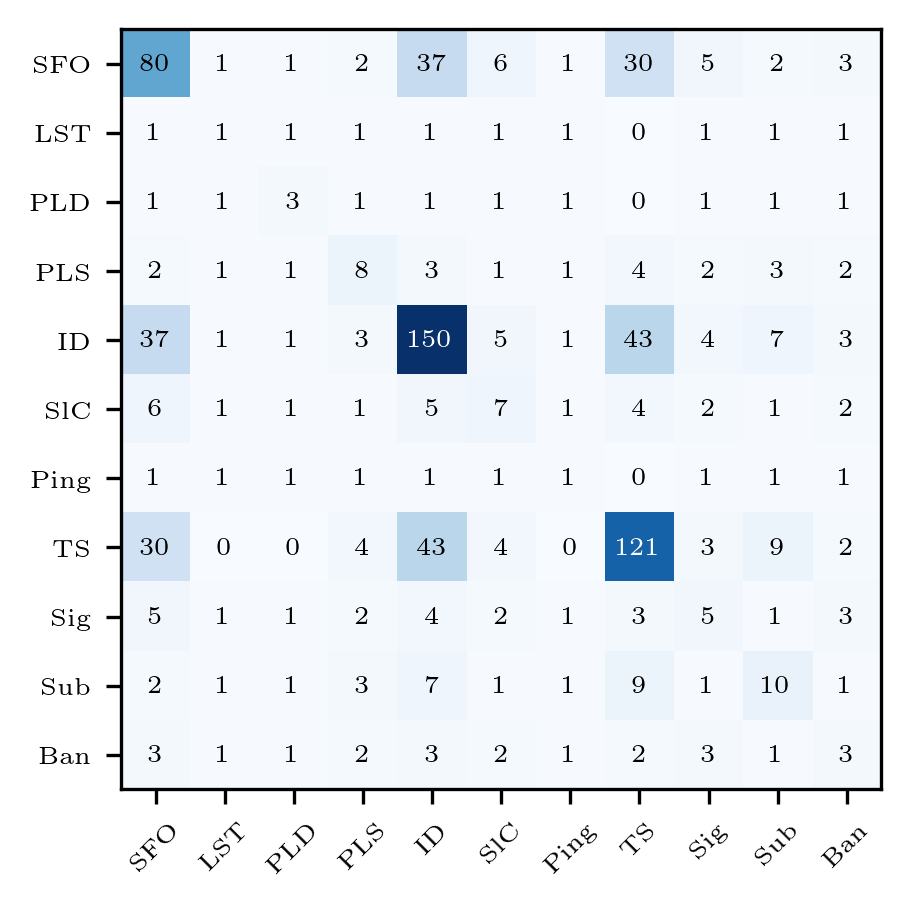

In [49]:
def plot_overlap_matrix(data_dict):
    keys = list(data_dict.keys())
    n = len(keys)
    matrix = np.zeros((n, n))
    
    for i, key1 in enumerate(keys):
        for j, key2 in enumerate(keys):
            overlap = len(set(data_dict[key1]['asns']) & set(data_dict[key2]['asns']))
            matrix[i, j] = overlap
    new_labels = ['SFO', 'LST', 'PLD', 'PLS', 'ID', 'SlC', 'Ping', 'TS', 'Sig', 'Sub', 'Ban']
    keys = new_labels
    plt.figure(figsize=(3.13, 3.13), dpi=300)
    plt.imshow(matrix, cmap='Blues')
    #plt.colorbar(label='Overlap Count')
    plt.xticks(range(n), keys, rotation=45, fontsize=6)
    plt.yticks(range(n), keys, fontsize=6)
    
    # Add values to cells
    for i in range(n):
        for j in range(n):
            if int(matrix[i, j]) > (matrix.max()-(matrix.max()/3)):
                plt.text(j, i, int(matrix[i, j]), ha='center', va='center', fontsize=6, color='white')
            else:
                plt.text(j, i, int(matrix[i, j]), ha='center', va='center', fontsize=6)
    
    plt.tight_layout()
    plt.savefig(f'results/graphs/{ban}_overlap_asns.pdf')
    plt.show()

plot_overlap_matrix(anomaly_dict)

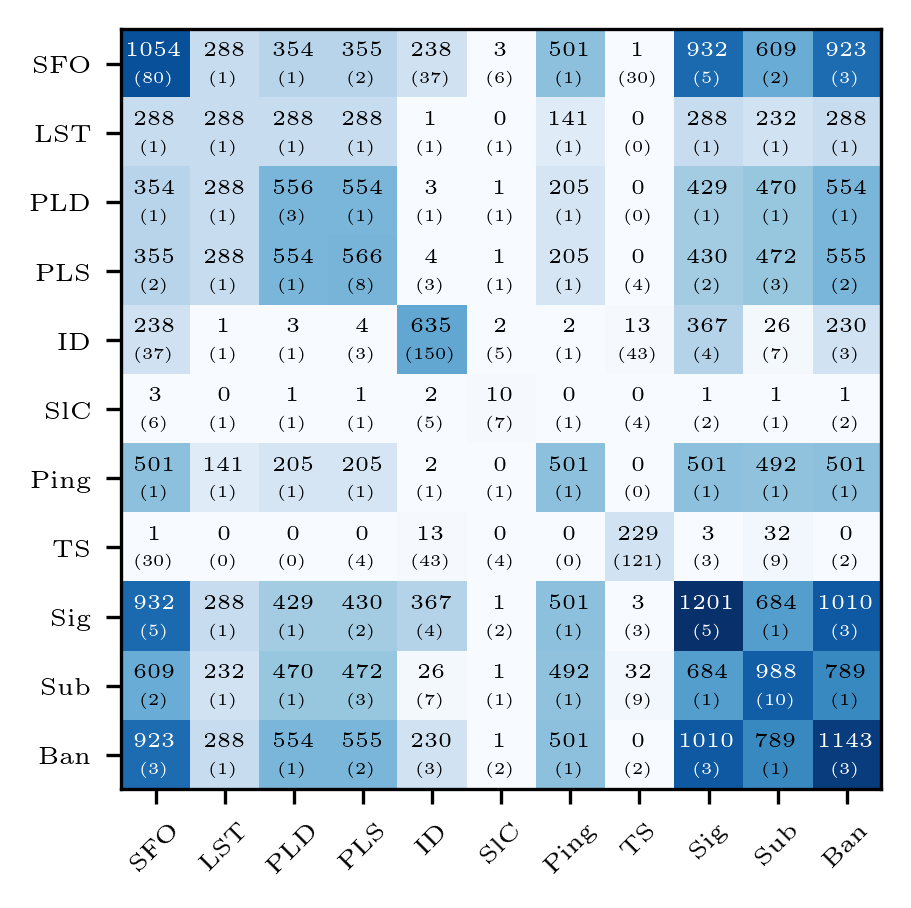

In [55]:
def plot_overlap_matrix(data_dict):
    keys = list(data_dict.keys())
    n = len(keys)
    matrix = np.zeros((n, n))
    matrix_asn = np.zeros((n, n))
    
    for i, key1 in enumerate(keys):
        for j, key2 in enumerate(keys):
            overlap = len(set(data_dict[key1]['ips']) & set(data_dict[key2]['ips']))
            overlap_asn = len(set(data_dict[key1]['asns']) & set(data_dict[key2]['asns']))
            matrix[i, j] = overlap
            matrix_asn[i, j] = overlap_asn

    new_labels = ['SFO', 'LST', 'PLD', 'PLS', 'ID', 'SlC', 'Ping', 'TS', 'Sig', 'Sub', 'Ban']
    keys = new_labels
    plt.figure(figsize=(3.13, 3.13), dpi=300)
    plt.imshow(matrix, cmap='Blues')
    #plt.colorbar(label='Overlap Count')
    plt.xticks(range(n), keys, rotation=45, fontsize=6)
    plt.yticks(range(n), keys, fontsize=6)
    
    # Add values to cells
    for i in range(n):
        for j in range(n):
            ip_val = int(matrix[i, j])
            asn_val = int(matrix_asn[i, j])
            
            if ip_val > (matrix.max()-(matrix.max()/3)):
                color = 'white'
            else:
                color = 'black'
                
            plt.text(j, i-0.2, ip_val, ha='center', va='center', fontsize=5, color=color)
            plt.text(j, i+0.2, f"({asn_val})", ha='center', va='center', fontsize=4, color=color)
    
    plt.tight_layout()
    plt.savefig(f'results/graphs/{ban}_overlap_ips_as.pdf')
    plt.show()

plot_overlap_matrix(anomaly_dict)

In [29]:
key_list = list(anomaly_dict.keys())
display(key_list)
key_list[4]

['SF Omission',
 'LS Transmission',
 'PL Diversity',
 'PL Similarity',
 'ID:IP Anomaly',
 'Short-lived Conn',
 'Ping Flooding',
 'Throttled TS',
 'Signature Only',
 'High Subnet Sat',
 'Ban Listed']

'ID:IP Anomaly'

In [40]:
def retrieve_overlap(data_dict, key1, key2):
    ips = set(data_dict[key1]['ips']) & set(data_dict[key2]['ips'])
    asns = set(data_dict[key1]['asns']) & set(data_dict[key2]['asns'])
    return ips, asns
    

overlap_ips, overlap_asns = retrieve_overlap(anomaly_dict, key_list[4], key_list[-4])
overlap_asns

{'31173 Services AB',
 'AMAZON-02',
 'AS-CMN',
 'ASN-CXA-ALL-CCI-22773-RDC',
 'ASN-STARRY',
 'ATT-INTERNET4',
 'Alexhost Srl',
 'Aussie Broadband',
 'British Telecommunications PLC',
 'CABLEONE',
 'CENTURYLINK-US-LEGACY-QWEST',
 'COMCAST-7922',
 'Contabo GmbH',
 'DIGITALOCEAN-ASN',
 'Data Communication Business Group',
 'Datacamp Limited',
 'Deutsche Telekom AG',
 'F3 Netze e.V.',
 'FRONTIER-FRTR',
 'Free SAS',
 'GMA',
 'GOOGLE-CLOUD-PLATFORM',
 'Global Layer B.V.',
 'Hetzner Online GmbH',
 'Korea Telecom',
 'M247 Europe SRL',
 'OCEANIC-INTERNET-RR',
 'OVH SAS',
 'Orange',
 'PacketHub S.A.',
 'QuxLabs AB',
 'ROUTERHOSTING',
 'Rostelecom',
 'SPACEX-STARLINK',
 'SSASN2',
 'SURF B.V.',
 'TWC-11351-NORTHEAST',
 'TWC-11427-TEXAS',
 'TZULO',
 'UUNET',
 'Verasel, Inc.',
 'Vivacom Bulgaria EAD',
 'Vodafone GmbH'}